In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
reload(mlutils)
import sklearn as sk
%config IPCompleter.greedy=True
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Lab: Convolutional network with TensorFlow low level API


### RECOMMENDATION

- close all applications
- install Maxthon browser http://www.maxthon.com
- open only VirtualBox and Maxthon


**Using a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**


In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

File ‘mini_cifar.h5’ already there; not retrieving.



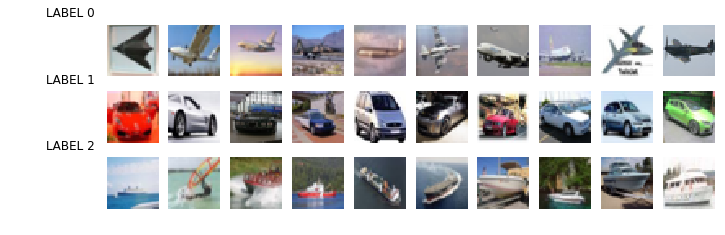

In [3]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()


(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    769
0    752
1    732
dtype: int64

distribution of test classes
2    256
0    253
1    242
dtype: int64


# Part 1: Build a CNN with TF Low Level API

### Build the convolutional network model

with the same architecture as in the corresponding notebook:

    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 32, 32, 15)        735       
    _________________________________________________________________
    flatten (Flatten)            (None, 15360)             0         
    _________________________________________________________________
    dense (Dense)                (None, 16)                245776    
    _________________________________________________________________
    output_1 (Dense)             (None, 3)                 51        
    =================================================================
    Total params: 246,562
    Trainable params: 246,562
    Non-trainable params: 0
    _________________________________________________________________

#### understand carefully the example [here](http://www.jessicayung.com/explaining-tensorflow-code-for-a-convolutional-neural-network/). 

Complete the following function. You will have to:

1. Declare tensor symbolic variables for inputs and model parameters:

    - Define placefolders for X and y
    - Define tf variables for W's and b's. You will have to think carefully about their shapes.


2. Build the computational graph

    - Use [tf.random_normal](https://www.tensorflow.org/api_docs/python/tf/random/normal) with mean 0 and std 1 as initialization distribuition for all W's and b's
    - Use [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) for the convolutional layer (`h_conv1`)
    - Use [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) to transition from the convolutional layer to the dense layer (`h_conv1_flat`)
    - Model the dense layer with TF matrix multiplication and relu activation (`h_dense`)
    - Model the output with three output neurons and softmax activation (`y_proba`)

the shapes of the weights your define must be equal to the ones printed out in the corresponding notebook.




In [5]:
#input_units  = 32*32 
strides=1
varianza=0.01 
def build_model(n_filters, filter_size, dense_size, img_size, n_channels):

    init_stddev = 0.01
    
    tf.reset_default_graph()
   
    tX = tf.placeholder(name="X", dtype=tf.float32, shape = (None,img_size,img_size,n_channels))
    
    ty = tf.placeholder(name="y", dtype=tf.int32, shape = (None))
   
    w_conv1 = tf.Variable(tf.random_normal([filter_size, filter_size, n_channels, n_filters],stddev=varianza))
    b_conv1 = tf.Variable(tf.random_normal([n_filters],stddev=varianza))
    
    w_dense = tf.Variable(tf.random_normal([img_size*img_size*n_filters, dense_size],stddev=varianza))
    b_dense = tf.Variable(tf.random_normal([dense_size],stddev=varianza))
    
    w_out   = tf.Variable(tf.random_normal([dense_size, n_classes],stddev=varianza))
    b_out   = tf.Variable(tf.random_normal([n_classes],stddev=varianza))
    
    with tf.name_scope("cnn"):
        
        h_conv1      = tf.nn.conv2d(tX, w_conv1, strides=[1, strides, strides, 1], padding='SAME')
        h_conv1      = tf.nn.bias_add(h_conv1, b_conv1)
        h_conv1      = tf.nn.relu(h_conv1)
        h_conv1_flat = tf.reshape(h_conv1, [-1, 32*32*15])
        

        h_dense      = tf.add(tf.matmul(h_conv1_flat, w_dense), b_dense)
        h_dense      = tf.nn.relu(h_dense)
        

        y_proba      = tf.add(tf.matmul(h_dense, w_out), b_out)
        y_proba      = tf.nn.softmax(y_proba)


    with tf.name_scope("cross_entropy"):
        y_hat        = tf.argmax(y_proba, axis=1)
        xentropy     = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_proba, labels=ty)

    with tf.name_scope("optimization"):
        loss         = tf.reduce_mean(xentropy)
        optimizer    = tf.train.AdamOptimizer()
        training_op  = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(y_proba,ty,1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()

    print "-- weights shape --"
    print w_conv1.shape
    print b_conv1.shape
    print w_dense.shape
    print b_dense.shape
    print w_out.shape
    print b_out.shape 

    return tX, ty, init, accuracy, training_op, loss

In [6]:
n_classes = len(np.unique(y_cifar))
print "using", n_classes, "classes"

n_filters   = 15
filter_size = 4
dense_size  = 16
n_channels  = 3 
img_size    = 32

n_epochs = 30
batch_size = 32


using 3 classes


In [7]:
tX, ty, init, accuracy, training_op, loss = build_model(n_filters, filter_size, dense_size, img_size, n_channels)

-- weights shape --
(4, 4, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


## Create the optimization loop

keep track of accuracy and loss in both train and test. Base your implementation on the notebook describing TF low level API.

Observe that accuracy must keep one metric per epoch averaging the accuracy obtained in all batches. Likewise for loss.

Plot the accuracy and loss curves for test and train separately, which should look like the following

![](Images/lab_batch_01.png)


realizar un seguimiento de la precisión y la pérdida tanto en el tren y la prueba. Base su implementación en el cuaderno que describe la API de bajo nivel de TF.

Observe que la precisión debe mantener una métrica por época que promedia la precisión obtenida en todos los lotes. Igualmente para la pérdida.

Grafique la precisión y las curvas de pérdida para la prueba y el tren por separado, que deben verse como las siguientes

In [8]:
num_examples = len(x_train)
acc_train, acc_test = [], []
loss_train, loss_test = [], []

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(n_epochs):
        
        idxs = np.random.permutation(len(x_train))
        eacc, eloss = [], []
        
        for iteration in range(num_examples // batch_size):
            

            X_batch = x_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            y_batch = y_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]

            _, _eacc, _eloss = sess.run([training_op, accuracy, loss], feed_dict={tX: X_batch, ty: y_batch})

            eacc += [_eacc]   
            eloss += [_eloss] 
        
        
        _eacct, _elosst = sess.run([ accuracy, loss], feed_dict={tX: x_test, ty: y_test})
        
        acc_train += [np.mean(eacc)]   #Promedios de precision entrenamiento
        acc_test  += [_eacct]          #Precision de test
        loss_train += [np.mean(eloss)] #Promedio de perdidad de entrenamiento 
        loss_test  += [_elosst]        #Perdida de test
        
        print "epoch: %3d"%(epoch+1), "  train accuracy: %.4f"%acc_train[-1], "  test accuracy: %.4f"%acc_test[-1], "  train loss: %.4f"%loss_train[-1], "  test loss: %.4f"%loss_test[-1]
       

epoch:   1   train accuracy: 0.4246   test accuracy: 0.5313   train loss: 1.0729   test loss: 1.0348
epoch:   2   train accuracy: 0.5879   test accuracy: 0.6232   train loss: 0.9672   test loss: 0.9230
epoch:   3   train accuracy: 0.6187   test accuracy: 0.6245   train loss: 0.9218   test loss: 0.9094
epoch:   4   train accuracy: 0.6272   test accuracy: 0.6391   train loss: 0.9127   test loss: 0.9082
epoch:   5   train accuracy: 0.6424   test accuracy: 0.6365   train loss: 0.8979   test loss: 0.8979
epoch:   6   train accuracy: 0.6576   test accuracy: 0.6551   train loss: 0.8854   test loss: 0.8914
epoch:   7   train accuracy: 0.6594   test accuracy: 0.6405   train loss: 0.8797   test loss: 0.9043
epoch:   8   train accuracy: 0.6719   test accuracy: 0.6738   train loss: 0.8703   test loss: 0.8803
epoch:   9   train accuracy: 0.6786   test accuracy: 0.6578   train loss: 0.8620   test loss: 0.8800
epoch:  10   train accuracy: 0.6897   test accuracy: 0.6711   train loss: 0.8550   test los

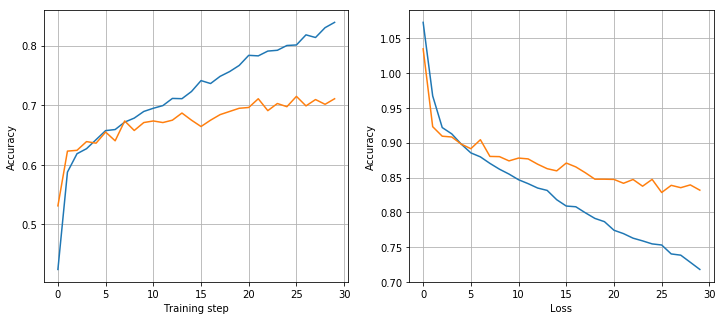

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc_train, label="acc train")
plt.plot(acc_test, label="acc test")
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.grid()
plt.subplot(1,2,2)
plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.grid()

# Part 2

Modify the optimization loop so that each batch is normalized before feeding it to the optimization step according to the following spec:

- consider only $X^{i}$ in the current batch
- $X^{i}$: image $i$
- $X^{i}_{j|k}$: channel $k$ of pixel $j$ in image $i$
- $S^i$: image $i$ standardized

In pixel wise standardization, each pixel has zero mean and std=1 across the dataset:

- $\mu = \frac{1}{N}\sum_{i,j,k} X^{i}_{j|k}$
- $\sigma = \frac{1}{N}\sum_{i,j,k}^{N-1}(X^{i}_{j|k}-\mu_{j|k})^2$

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma + 10^{-6}}(X^{i}_{j|k} - \mu)$$


The $10^{-6}$ is to avoid the case of zero variance

you must also plot:

- accuracy and loss curves for train and test separately, which should look better than the previous

![](Images/lab_batch_02.png)

- for only train, the accuracy and loss curves of both experiments, looking like this

![](Images/lab_batch_03.png)


In [10]:
tX, ty, init, accuracy, training_op, loss = build_model(n_filters, filter_size, dense_size, img_size, n_channels)

-- weights shape --
(4, 4, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


In [11]:
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]
sx_train = np.r_[[(i-np.mean(i))/np.std(i) for i in x_train]]
#sx_train=x_train

In [12]:
num_examples = len(x_train)
bacc_train, bacc_test = [], []
bloss_train, bloss_test = [], []
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
                
        idxs = np.random.permutation(len(sx_train))
        eacc, eloss = [], []
        for iteration in range(num_examples // batch_size):
            
            
            X_batch = sx_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            y_batch = y_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            
            
            _, _eacc, _eloss = sess.run([training_op, accuracy, loss], feed_dict={tX: X_batch, ty: y_batch})
           
            eacc += [_eacc]
            eloss += [_eloss]
        
        _eacct, _elosst = sess.run([accuracy, loss], feed_dict={tX: sx_test, ty: y_test})
        bacc_train += [np.mean(eacc)]
        bacc_test  += [_eacct]
        bloss_train += [np.mean(eloss)]
        bloss_test  += [_elosst]
      
        print "epoch: %3d"%(epoch+1), "  train accuracy: %.4f"%bacc_train[-1], "  test accuracy: %.4f"%bacc_test[-1], "  train loss: %.4f"%bloss_train[-1], "  test loss: %.4f"%bloss_test[-1]

epoch:   1   train accuracy: 0.5625   test accuracy: 0.6205   train loss: 0.9772   test loss: 0.9261
epoch:   2   train accuracy: 0.6473   test accuracy: 0.6471   train loss: 0.8990   test loss: 0.8940
epoch:   3   train accuracy: 0.6545   test accuracy: 0.6671   train loss: 0.8837   test loss: 0.8739
epoch:   4   train accuracy: 0.6879   test accuracy: 0.6631   train loss: 0.8523   test loss: 0.8750
epoch:   5   train accuracy: 0.7165   test accuracy: 0.6551   train loss: 0.8306   test loss: 0.8779
epoch:   6   train accuracy: 0.7335   test accuracy: 0.6778   train loss: 0.8115   test loss: 0.8599
epoch:   7   train accuracy: 0.7567   test accuracy: 0.6644   train loss: 0.7931   test loss: 0.8702
epoch:   8   train accuracy: 0.7616   test accuracy: 0.7017   train loss: 0.7846   test loss: 0.8496
epoch:   9   train accuracy: 0.7665   test accuracy: 0.6844   train loss: 0.7802   test loss: 0.8595
epoch:  10   train accuracy: 0.7879   test accuracy: 0.6897   train loss: 0.7614   test los

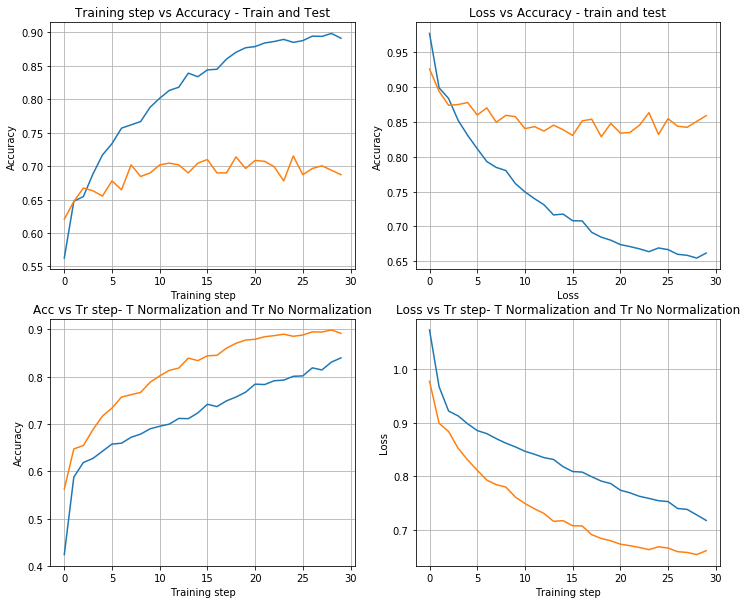

In [25]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.title('Training step vs Accuracy - Train and Test')
plt.plot(bacc_train,label="bacc train")
plt.plot(bacc_test, label="bacc test")
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.grid()
plt.subplot(2,2,2)
plt.title('Loss vs Accuracy - train and test')
plt.plot(bloss_train, label="bloss train")
plt.plot(bloss_test, label="bloss test")
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.grid()


plt.subplot(2,2,3)
plt.title('Acc vs Tr step- T Normalization and Tr No Normalization')
plt.plot(acc_train, label="train")
plt.plot(bacc_train, label="train normalize")
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.grid()

plt.subplot(2,2,4)
plt.title('Loss vs Tr step- T Normalization and Tr No Normalization')
plt.plot(loss_train, label="loss")
plt.plot(bloss_train, label="Loss normalize")
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.grid()